# Project - 2019 2nd ML month with KaKR

In [31]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### (1) 데이터 가져오기

In [14]:
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [16]:
train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(sub.shape))

train.head()

train data dim : (15035, 21)
sub data dim : (6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### (2) 데이터 전처리

__결측치가 있는지 전체적으로 확인한다.__

In [18]:
for c in train.columns:
    print(f'{c} : {len(train.loc[pd.isnull(train[c]), c].values)}')

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


__id는 필요없으므로 지우고, date는 년월 정보만 남도록 slicing 한다.__  
__price는 y 변수에 label로 따로 저장한다.__

In [19]:
y = train['price']
del train['price']
del train['id']
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)

train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [20]:
del sub['id']
sub['date'] = sub['date'].apply(lambda i: i[:6]).astype(int)

sub.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


__변수들의 분포를 확인한다.__  
__한 쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않으므로 다듬어주어야 한다.__

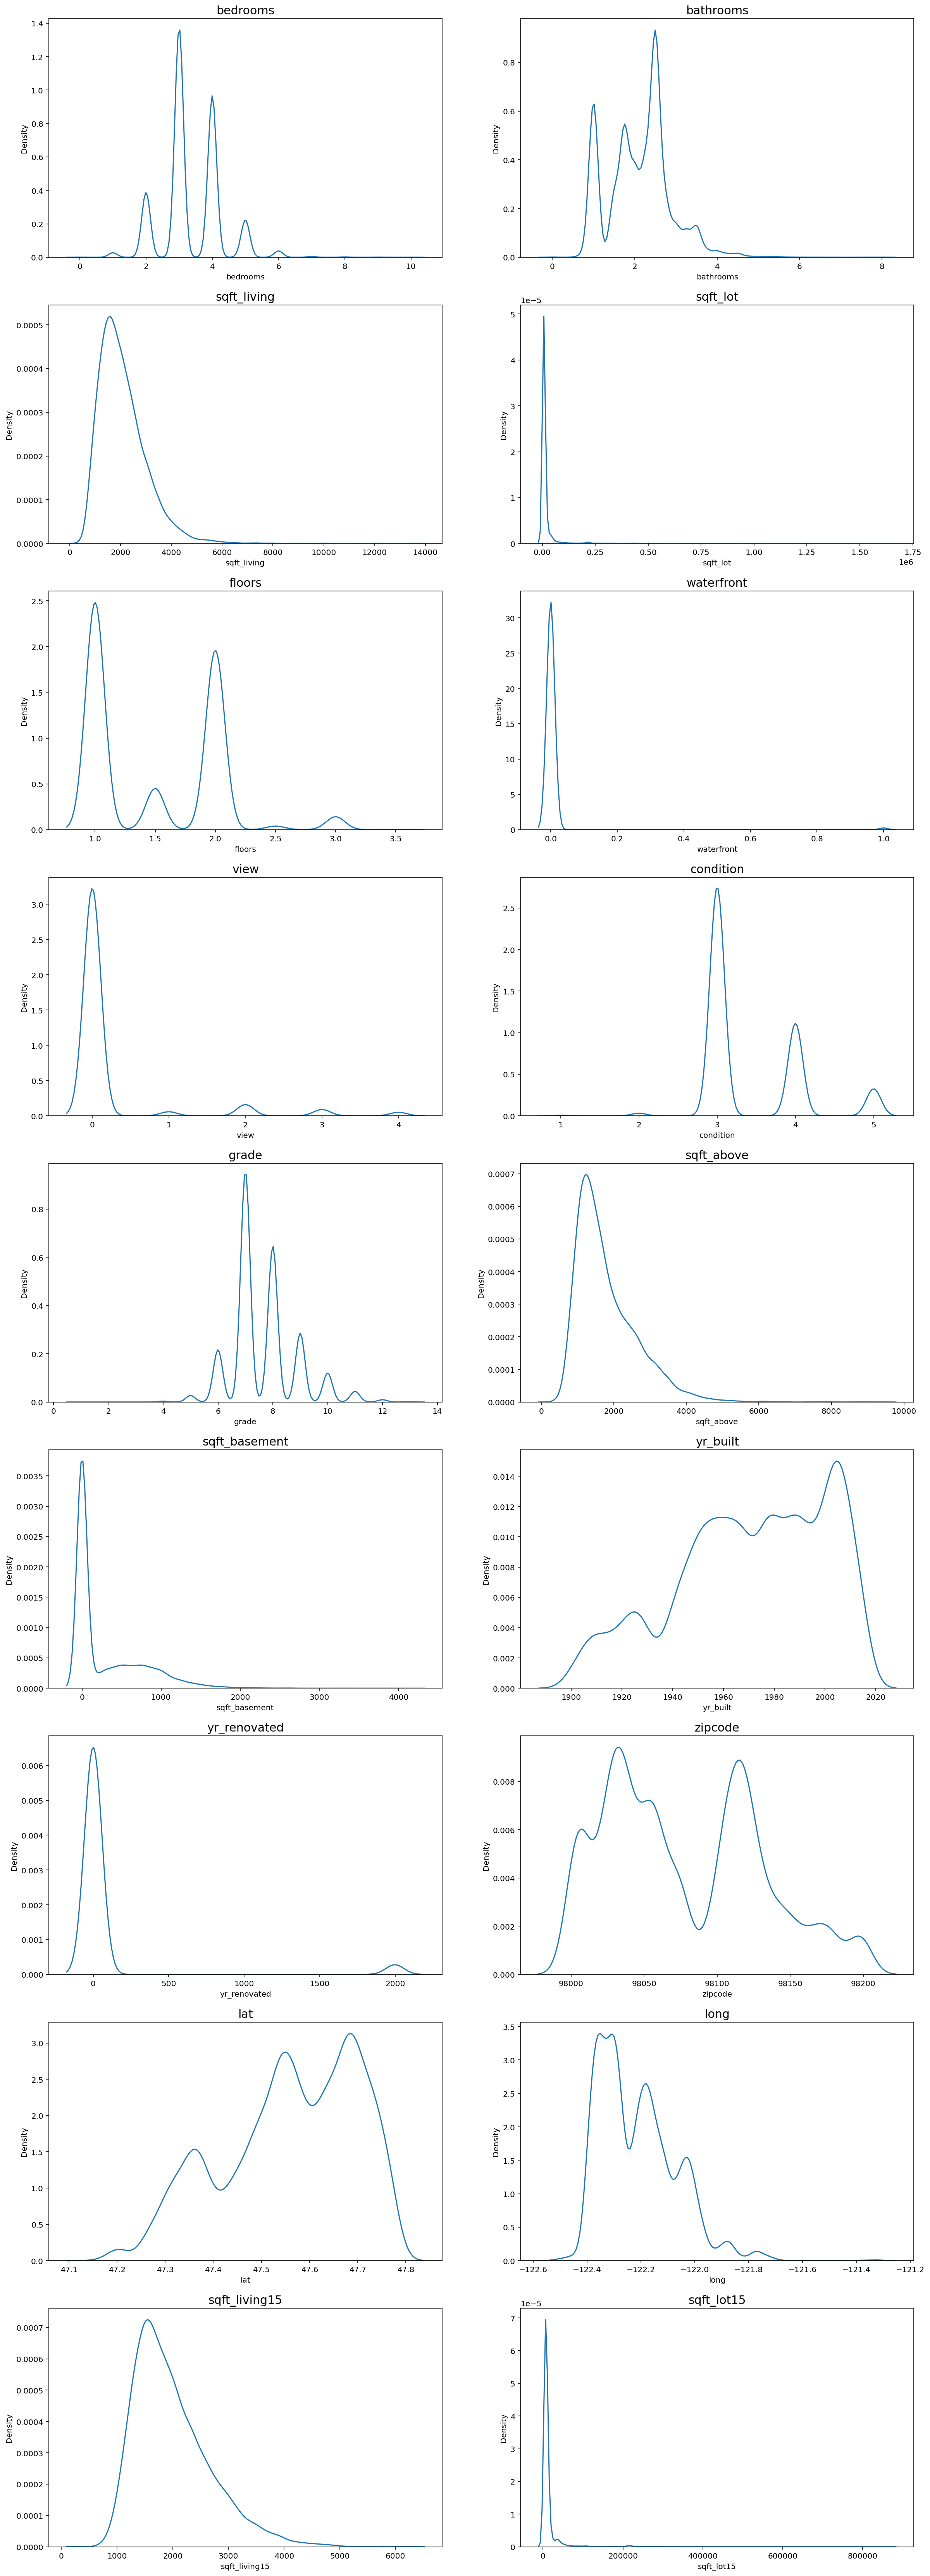

In [24]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# date 변수는 제외하고 분포를 확인한다.
count = 1
columns = train.columns

for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        
        if count == 19 :
            break

<AxesSubplot:xlabel='price', ylabel='Density'>

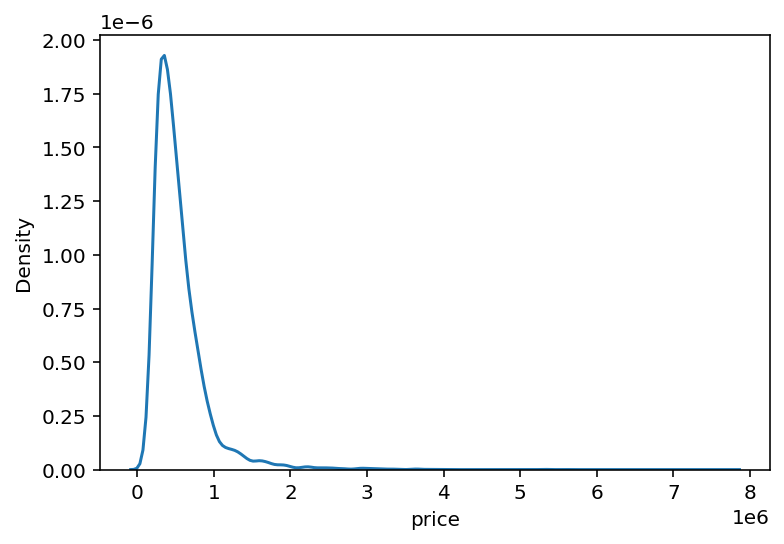

In [26]:
sns.kdeplot(data=y)

__변수가 한쪽으로 치우친 경향을 보인 컬럼을 log-scaling을 통해 정규분포에 가깝게 만든다.__

In [27]:
skew_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

y = np.log1p(y)

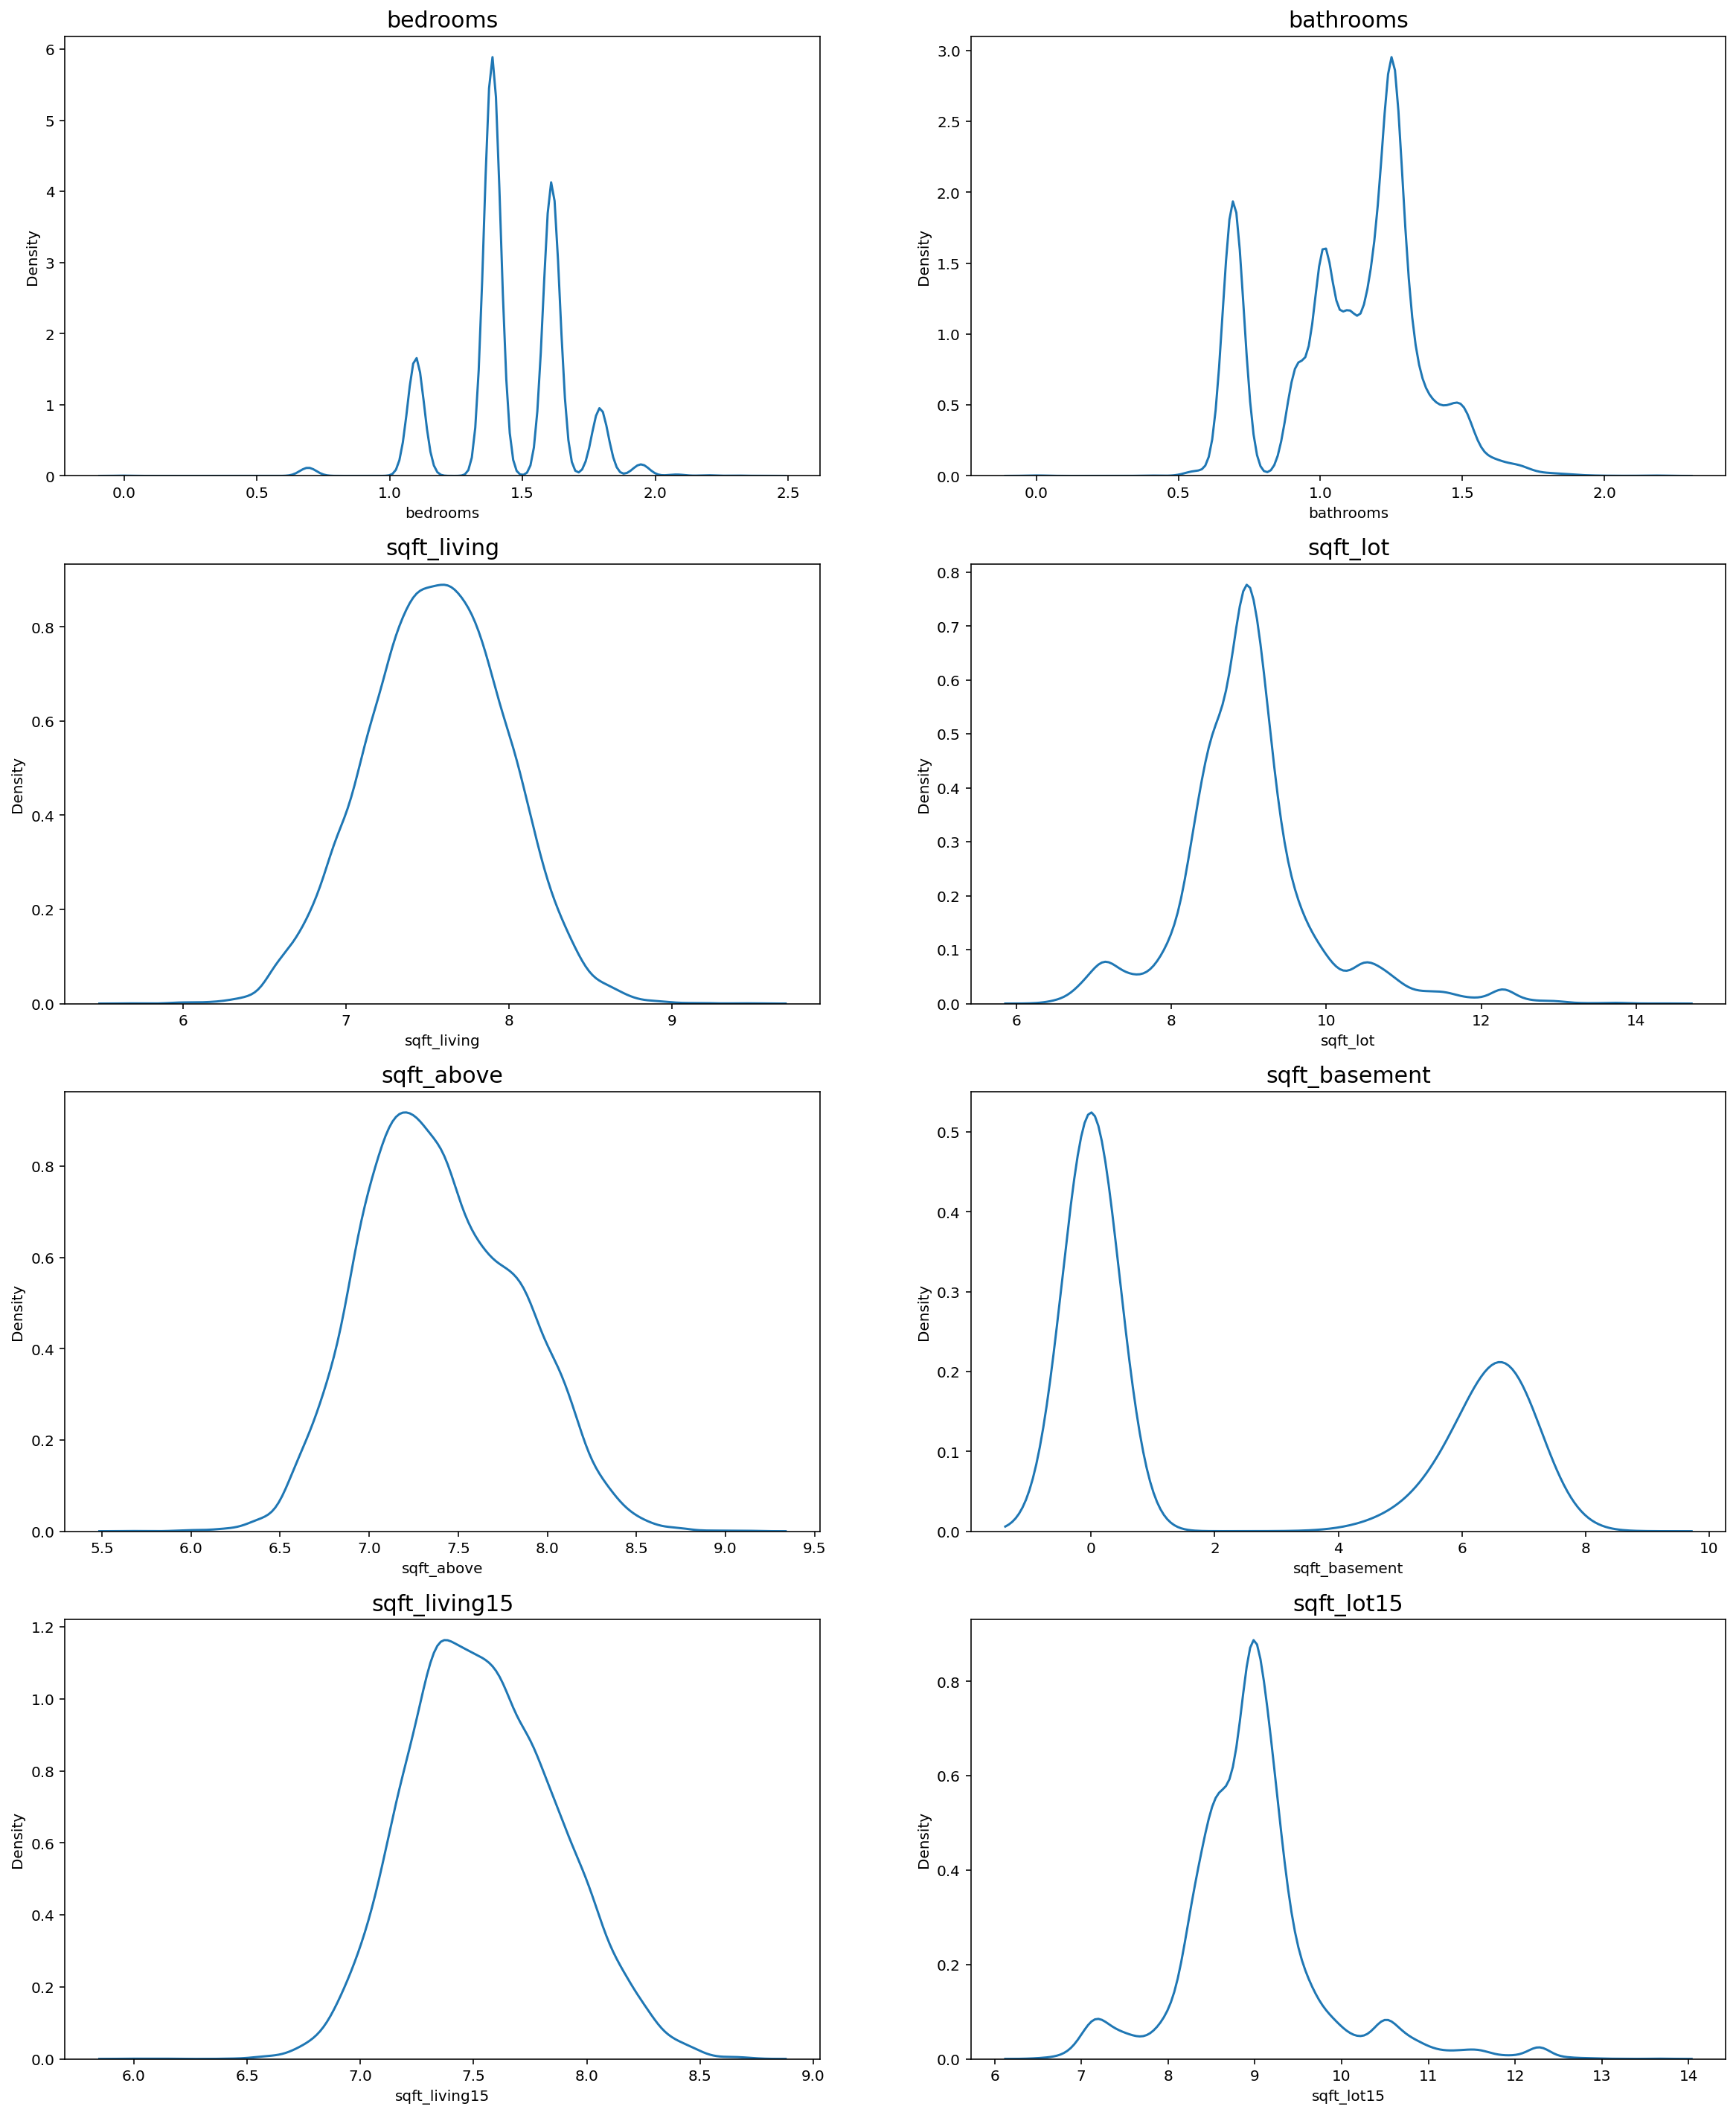

In [28]:
fig, ax = plt.subplots(4, 2, figsize=(20, 25))

count = 0
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

<AxesSubplot:xlabel='price', ylabel='Density'>

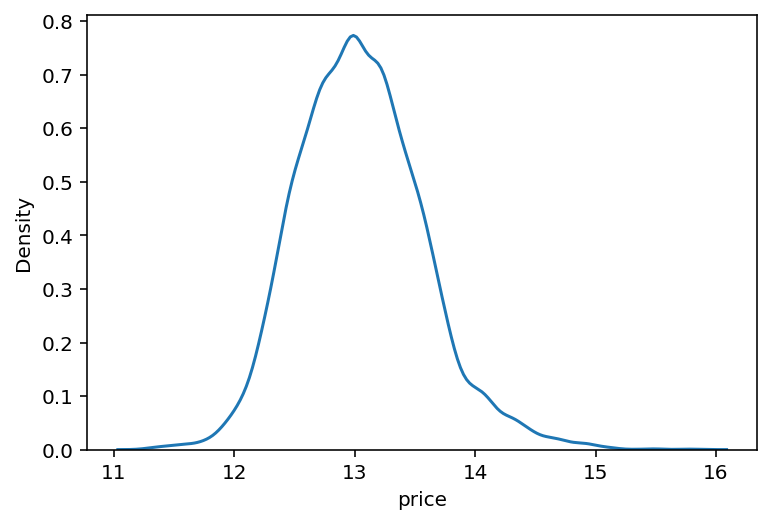

In [29]:
sns.kdeplot(data=y)

__어느 정도 치우침이 줄어든 분포를 확인할 수 있다.__

### (3) 모델링

__여러 가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만든다.__

In [76]:
rs = 2020

gboost = GradientBoostingRegressor(random_state=rs)
xgboost = XGBRegressor(random_state=rs)
lightgbm = LGBMRegressor(random_state=rs)
rdforest = RandomForestRegressor(random_state=rs)

models = [{'model':gboost, 'name':'GradientBoost'},
          {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},
          {'model':rdforest, 'name':'RandomForest'}]

__데이터셋을 train, test로 나누고 RMSE를 계산한다.__

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [78]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [79]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        # train, test 데이터셋 분리
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=rs)

        # 모델 학습
        model['model'].fit(X_train, y_train)
        
        # 예측
        y_pred = model['model'].predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model['name']] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

In [80]:
get_scores(models, train, y)

,RMSE
GradientBoost,128370.486911
RandomForest,125303.558748
LightGBM,111906.268088
XGBoost,110319.723794


### (4) 하이퍼 파라미터 튜닝

In [40]:
from sklearn.model_selection import GridSearchCV

In [81]:
def my_GridSearch(model, train, y, pg, cv=5, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=pg, scoring='neg_mean_squared_error', cv=cv, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

__각 모델에 대한 하이퍼 파라미터 튜닝__

In [82]:
pg = {
    'learning_rate': [0.1, 0.15, 0.2],
    'num_iterations': [100, 500, 1000]
}

In [ ]:
my_GridSearch(xgboost, train, y, pg)

In [ ]:
my_GridSearch(lightgbm, train, y, pg)

In [ ]:
my_GridSearch(rdforest, train, y, pg)

In [58]:
xgboost = XGBRegressor(learning_rate=0.15, random_state=rs)
lightgbm = LGBMRegressor(learning_rate=0.15, random_state=rs)
rdforest = RandomForestRegressor(random_state=rs)

In [59]:
models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},
          {'model':rdforest, 'name':'RandomForest'}]

### (5) Make Submission

In [68]:
def AveragingBlending(models, x, y, sub):
    for model in models : 
        model['model'].fit(x, y)
    
    predictions = np.column_stack([model['model'].predict(sub) for model in models])
    predictions = np.expm1(predictions)
    
    return np.mean(predictions, axis=1)

In [69]:
y_pred = AveragingBlending(models, train, y, sub)
print(len(y_pred))

6468


In [70]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [71]:
my_submission = pd.DataFrame(data={'id':submission['id'], 'price':y_pred})
my_submission.head()

,id,price
0,15035,8.495561e+05
1,15036,8.178292e+05
2,15037,1.737136e+06
3,15038,6.235878e+05
4,15039,6.828959e+05


In [73]:
score_df = get_scores(models, train, y)
my_rmse = np.mean(score_df['RMSE'])
print(my_rmse)

123884.47375694988


In [74]:
my_submission_path = '{}/submission_{}_RMSE_{:.0f}.csv'.format(data_dir, 'LXR', my_rmse)
my_submission.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LXR_RMSE_123884.csv


In [75]:
submission = pd.read_csv(my_submission_path)
submission.head()

,id,price
0,15035,8.495561e+05
1,15036,8.178292e+05
2,15037,1.737136e+06
3,15038,6.235878e+05
4,15039,6.828959e+05
